In [1]:
import numpy as np

# Ajustá esto a tu caso: tipo de datos y nombre de archivo
input_file = '../records/captura_pon_us_ch2_20250707_100742.csv'
#samples = np.fromfile(file, dtype=np.float32)  # o int8, int16, complex64, etc.

datos = np.loadtxt(f'{input_file}', delimiter=',')
samples = datos[:, 1].astype(np.float32)

In [2]:
print(f"Tamaño total de samples: {len(samples)}")

num_symbols = len(samples) // 16 # 16 muestros por símbolo
print(f"Número total de símbolos: {num_symbols}")

Tamaño total de samples: 8000002
Número total de símbolos: 500000


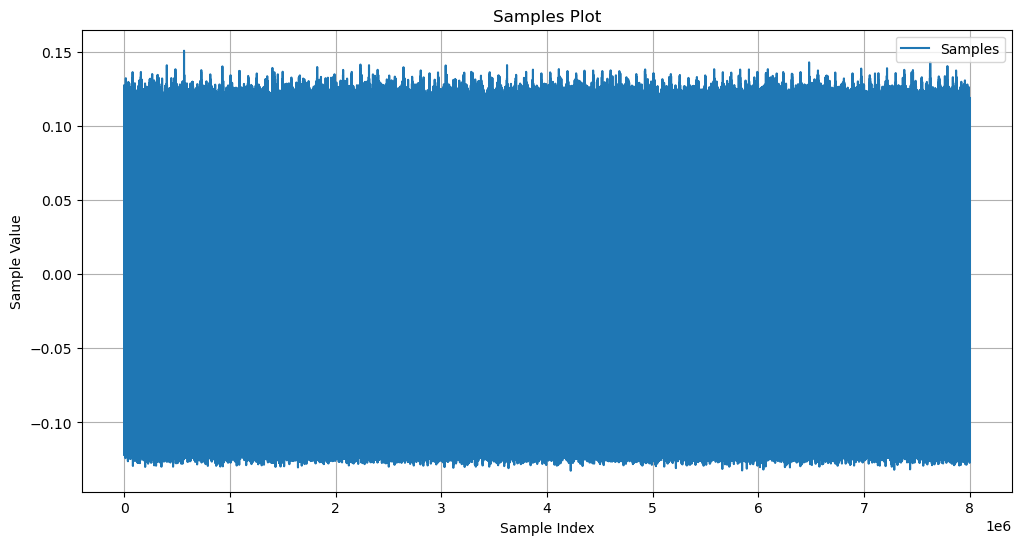

In [3]:
# plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(samples, label='Samples')
plt.title('Samples Plot')
plt.xlabel('Sample Index')
plt.ylabel('Sample Value')
plt.legend()
plt.grid()
plt.show()

In [4]:
min_sample = samples.min()
max_sample = samples.max()

print(f"Mínimo de las muestras: {min_sample}")
print(f"Máximo de las muestras: {max_sample}")

Mínimo de las muestras: -0.13257412612438202
Máximo de las muestras: 0.15082968771457672


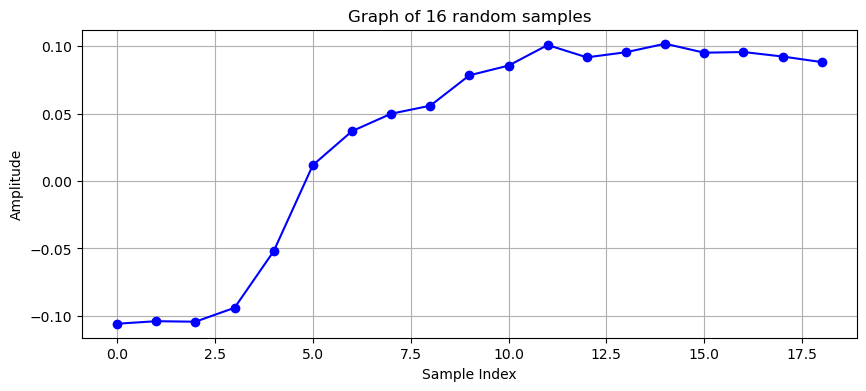

Señal filtrada aplicada con frecuencia de corte: 2500000000.0 Hz


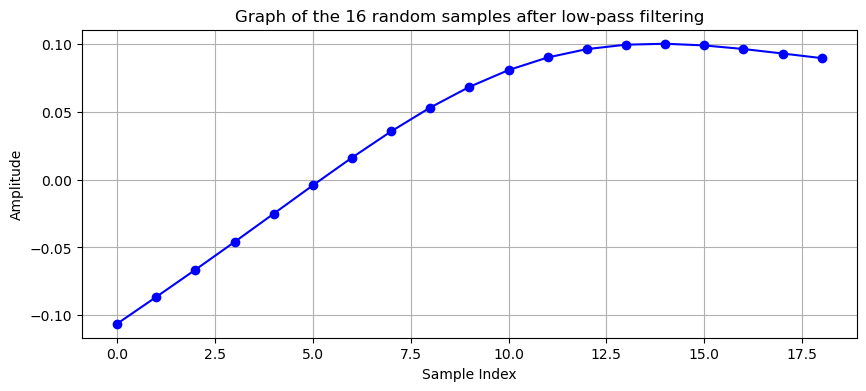

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


samples_to_plot = samples[1+31:1+50]

# Plot the samples
plt.figure(figsize=(10, 4))
plt.plot(samples_to_plot, marker='o', linestyle='-', color='blue')
plt.title("Graph of 16 random samples")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

def low_pass_filter(data, cutoff_freq, sampling_rate):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

sampling_rate = 40e9  # Tasa de muestreo (40 Gbps)
cutoff_freq = 2.5e9  # Frecuencia de corte (2.5 GHz)

filtered_samples = low_pass_filter(samples_to_plot, cutoff_freq, sampling_rate)
print(f"Señal filtrada aplicada con frecuencia de corte: {cutoff_freq} Hz")

plt.figure(figsize=(10, 4))
plt.plot(filtered_samples, marker='o', linestyle='-', color='blue')
plt.title("Graph of the 16 random samples after low-pass filtering")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Número de símbolos a graficar: 49766


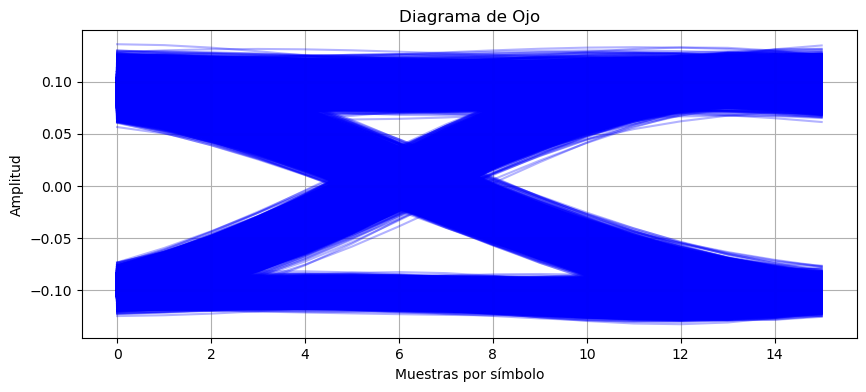

In [6]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import resample_poly

import matplotlib.pyplot as plt
# Parámetros
start_idx = 0#1 + 32*128
samples_per_symbol = 16
num_symbols_to_plot = int(800000 // samples_per_symbol)  # Asegurar que sea un número entero
                        # usar 8000000 para un diagrama entero
                        
# Extraer las muestras necesarias
end_idx = int(start_idx + num_symbols_to_plot * samples_per_symbol)  # Convertir a entero

subset_samples = samples[start_idx:end_idx]

# Filtrar las muestras
cutoff_freq = 2.5e9  # Frecuencia de corte (1.25 GHz)
sampling_rate = 40e9  # Tasa de muestreo (40 Gbps)
filtered_subset_samples = low_pass_filter(subset_samples, cutoff_freq, sampling_rate)

# resampleo
up = 972*32
down = 31250
resampled = resample_poly(filtered_subset_samples, up, down)

num_symbols_to_plot = int(len(resampled) // samples_per_symbol)  # Asegurar que sea un número entero
print(f"Número de símbolos a graficar: {num_symbols_to_plot}")

# Crear el diagrama de ojo
eye_diagram = np.zeros((num_symbols_to_plot, int(np.ceil(samples_per_symbol))))  # Ajustar tamaño

for i in range(num_symbols_to_plot):
    start = int(i * samples_per_symbol)
    end = start + samples_per_symbol
    if end > len(resampled):
        break
    trace = resampled[start:end]
    
    # Interpolación para ajustar a un número entero de muestras por símbolo
    x_original = np.linspace(0, 1, len(trace))
    x_target = np.linspace(0, 1, int(np.ceil(samples_per_symbol)))  # Redondear hacia arriba
    interpolator = interp1d(x_original, trace, kind='linear', fill_value="extrapolate")
    eye_diagram[i, :] = interpolator(x_target)

# Mostrar el diagrama de ojo
plt.figure(figsize=(10, 4))
for trace in eye_diagram:
    plt.plot(trace, color='blue', alpha=0.3)
plt.title("Diagrama de Ojo")
plt.xlabel("Muestras por símbolo")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

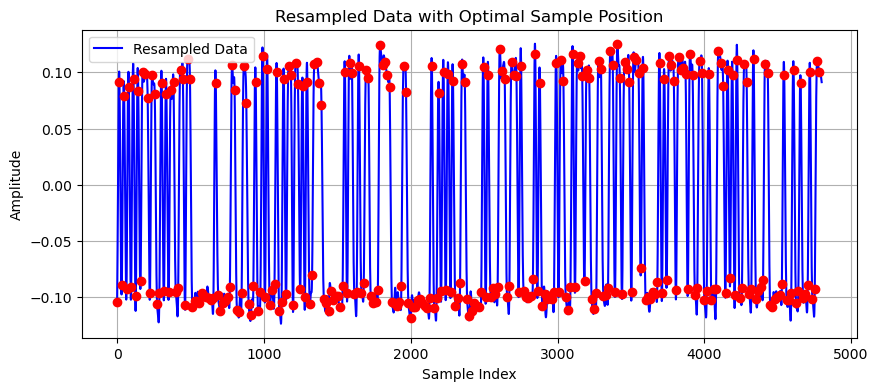

In [15]:
import numpy as np
import matplotlib.pyplot as plt
start_sample = (9440 + 32 + 13) * 16
end_sample = (9440 + 32 + 13 + 300) * 16
optimal_sample_position = 0  # Posición de la muestra con el ojo más abierto
resampled_data = resampled[start_sample:end_sample]
plt.figure(figsize=(10, 4))
plt.plot(resampled_data, label='Resampled Data', color='blue')

for i in range(0, len(resampled_data), samples_per_symbol):
    if i + optimal_sample_position < len(resampled_data):
        plt.plot(i + optimal_sample_position, resampled_data[i + optimal_sample_position], 'ro')
        #plt.text(i + optimal_sample_position, resampled_data[i + optimal_sample_position], 'Optimal', color='red')
plt.title("Resampled Data with Optimal Sample Position")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

 

In [16]:

samples_per_symbol = 16
optimal_sample_position = 13 # Posición de la muestra con el ojo más abierto
num_symbols_to_plot = len(filtered_subset_samples) // samples_per_symbol

threshold = 0

decoded_bits = []
for i in range(num_symbols_to_plot):
    sample_idx = i * samples_per_symbol + (optimal_sample_position)
    sample_value = filtered_subset_samples[sample_idx]
    decoded_bits.append(1 if sample_value > threshold else 0)

decoded_bits = np.array(decoded_bits, dtype=np.uint8)
print(f"Bits decodificados: {decoded_bits}")

Bits decodificados: [1 0 1 ... 1 0 0]


In [17]:
# ATENCIÓN. no reproducir esta celda

# save decoded_bits into a file, but as a string of bits
output_file = '../records/decoded_bits_us_ch2_0onu.csv'
with open(output_file, 'w') as f:
    f.write(''.join(map(str, decoded_bits)))
print(f"Bits decodificados guardados en: {output_file}")

Bits decodificados guardados en: ../records/decoded_bits_us_ch2_0onu.csv


In [18]:
import numpy as np

# read the file from output_file and save it in a variable, then search for the starting index of the sequence 10110110101010110011000111100000
output_file = '../records/decoded_bits_us_ch2_0onu.csv'

with open(output_file, 'r') as f:
    decoded_bits_str = f.read().strip()
search_sequence = '10110110101010110011000111100000'

# search for all the indexes of the search_sequence in decoded_bits_str
start_indices = []
index = decoded_bits_str.find(search_sequence)
while index != -1:
    start_indices.append(index)
    index = decoded_bits_str.find(search_sequence, index + 1)

print(f"Índices de inicio de la secuencia '{search_sequence}': {start_indices}")


# save the decoded_bits_str as an array
decoded_bits_array = np.array(list(decoded_bits_str), dtype=np.uint8)

Índices de inicio de la secuencia '10110110101010110011000111100000': []


In [14]:
def descrambler(input_bits):
    reg = [1] * 7
    output_bits = []

    for b_in in input_bits:
        scramble_bit = reg[6]
        b_out = b_in ^ scramble_bit
        output_bits.append(b_out)

        feedback = reg[6] ^ reg[5]
        reg = [feedback] + reg[:-1]
        

    return output_bits

'''
10110110101010110011000111100000  
PSync (4 bytes)

Ident (4 bytes)

PLOAMd (13 bytes)

Plend1 (1 byte)

Plend2 (1 byte)
'''
start_index = start_indices[0]  # Usar el segundo índice encontrado


# desde que termina PSync (start_index + 32) hasta 40*32 elementos posteriores, descramblea los bits
start_scrambled_data = start_index + 32
end_scrambled_data = start_scrambled_data + 8*100  # Ajustar el número de bytes a procesar

scrambled_data = decoded_bits_array[start_scrambled_data:end_scrambled_data]

data_raw = decoded_bits_str[start_scrambled_data-32:end_scrambled_data]
print(f'Data: {data_raw}')

PostSync_d = descrambler(scrambled_data)

# solo para probar: 
PostSync_d_str = ''.join(map(str, PostSync_d))
print(f"PostSync descrambled: {PostSync_d_str}")

Ident = PostSync_d_str[:32] # sumo 4 bytes para Ident
PLOAMd = PostSync_d_str[32:32 + 13 * 8] # sumo 13 bytes para PLOAMd
bip = PostSync_d_str[32 + 13 * 8:32 + 13 * 8 + 8] # sumo 8 bits para bip
Plend = PostSync_d_str[32 + 13 * 8 + 8:32 + 13 * 8 + 8 + 8*4*2] # sumo 4 bytes para Plend1
end_Plend_index = 32 + 13 * 8 + 8 + 8*4 + 8 * 4

print(f"Ident: {Ident}")
print(f"PLOAMd: {PLOAMd}")
print(f"BIP: {bip}")
print(f"Plend: {Plend}")

# 1010100011111010001011001100000111111101000001100010010011110001

IndexError: list index out of range

In [12]:
# el primer bit de IDENT es el FEC_Ind, el segundo bit es Resevered y los siguientes 30 bits son Superframe_counter
###
# IDENT
      ###

FEC_Ind = Ident[0]
Reserved = Ident[1]
Superframe_counter = Ident[2:]
print(f'\nIDENT -------')
print(f"FEC_Ind: {FEC_Ind}")
print(f"Reserved: {Reserved}")
print(f"Superframe_counter: {Superframe_counter}")

###
# PLOAMd
        ###
#primer octeto es ONU_ID segundo octeto es Message_ID, los siguientes 10 octetos son Data y el último octeto es CRC
ONU_ID = PLOAMd[:8]
Message_ID = PLOAMd[8:16]
Data = PLOAMd[16:96]
CRC = PLOAMd[96:104]

print(f'\nPLOAMd -------')
print(f"ONU_ID: {ONU_ID}") # FF es para todas las ONUs
print(f"Message_ID: {Message_ID}")
print(f"Data: {Data}")
print(f"CRC: {CRC}")

###
# BIP
      ###
BIP = int(bip, 2)
print(f'\nBIP -------')
print(f"BIP: {BIP}")

###
# Plend
      ###
# Blen es el largo del bandwidth map y está dado en los primeros 12 bits del Plend
#The length of the ATM partition (Alen) is given by the next 12 bits of the PLend field. The Alen field should contain all zeros.
#The last 8 bits of the PLend field consist of a CRC-8, u
# 
Blen = int(Plend[:12], 2)
Alen = int(Plend[12:24], 2)  # Alen es el largo del ATM partition, que debería ser 0
crc = Plend[24:]

print(f'\nPlend1 -------')
print(f"Blen1: {Blen}")
print(f"Alen1: {Alen}")
print(f"CRC1: {crc}")

###
# BWmap
      ###
# Hay 8*Blen bandiwths maps
BWmap = []


for i in range(Blen):
      start = end_Plend_index + i * 8*8
      end = start + 8*8
      BWmap.append(PostSync_d_str[start:end])

print(f'\nBWmap -------')

alloc_struct = []
for i, bw in enumerate(BWmap[:10]):
      # save in alloc_struct array
      alloc_struct.append({
          'index': i,
          'BWmap': bw  
      })




NameError: name 'Ident' is not defined

In [ ]:
# in the strings of bits Post_Sync_d find if there is a sequence of 32 bits that repeats at any place
i = 0

n_bits = 16
while i < len(PostSync_d_str) - n_bits:
    sequence = PostSync_d_str[i:i + n_bits]
    if PostSync_d_str.count(sequence) > 1:
        print(f"Found repeating sequence: {sequence}, at index {i}")
        i += n_bits  # Saltar al siguiente bloque de 32 bits
    else:
        i += 1  # Avanzar un bit
else:
    print("No more repeating sequences found.")
# in the strings of bits Post_Sync_d find if there is a sequence of 32 bits that repeats at any place


Found repeating sequence: 0000000001010000 at index 14
Found repeating sequence: 0000000000001010 at index 49
Found repeating sequence: 0100101110111001 at index 96
Found repeating sequence: 1010001111101000 at index 146
Found repeating sequence: 1100110010010111 at index 216
Found repeating sequence: 1100110010010111 at index 234
Found repeating sequence: 1001101000011000 at index 422
Found repeating sequence: 1101001111111010 at index 464
Found repeating sequence: 0000000000001010 at index 578
Found repeating sequence: 1010001111101000 at index 614
Found repeating sequence: 1101001111111010 at index 706
Found repeating sequence: 1001101000011000 at index 732
No more repeating sequences found.


In [119]:
hexa = '002000AE'

#bits of hexa
bits = bin(int(hexa, 16))[2:].zfill(32)
print(f"Bits of hexa {hexa}: {bits}")

Blen = int(bits[:12], 2)
Alen = int(bits[12:24], 2)  # Alen es el largo del ATM partition, que debería ser 0
crc = bits[24:]

print(f'\nPlend1 -------')
print(f"Blen1: {Blen}")
print(f"Alen1: {Alen}")
print(f"CRC1: {crc}")


Bits of hexa 002000AE: 00000000001000000000000010101110

Plend1 -------
Blen1: 2
Alen1: 0
CRC1: 10101110


In [104]:
# Chequeo si el scrambler está funcionando correctamente, se para la siguiente cadena de bits su correspondiente scramble

hexa_string = '00 05 12 76 12 13 21 01 05 00 00 00 00 00 00 00 CA 55 00 20 00 AE 00 20 00 AE'
def hex_to_bit_string(hex_string):
    hex_string = hex_string.replace(' ', '')  # Eliminar espacios
    return ''.join(format(int(c, 16), '04b') for c in hex_string)
bit_string = hex_to_bit_string(hexa_string)

descrambled_bit_string = descrambler(list(map(int, bit_string)))
descrambled_bit_string_str = ''.join(map(str, descrambled_bit_string))
print(f"Descrambled bit string: {descrambled_bit_string_str}")

# imprimir bit_string como hexadecimal
print(f"Original bit string in hex: {hex(int(bit_string, 2))}")
# ahora imprimirlos como hexadecimales 
print(f"Descrambled bit string in hex: {hex(int(descrambled_bit_string_str, 2))}")


Descrambled bit string: 1111111000000001000010100010011111110110010010101111010111111011000110010100100110110101101111011000110100101110111001100101010100110110010111010011000010000011110010000001110110101001110101000011100000111101
Original bit string in hex: 0x51276121321010500000000000000ca55002000ae002000ae
Descrambled bit string in hex: 0xfe010a27f64af5fb1949b5bd8d2ee655365d3083c81da9d4383d


In [24]:
start_burst_header = pattern_indices[0] + len(plim_pattern)
header = decoded_bits[start_burst_header:start_burst_header + 24]

In [33]:
def descramble(data_bits):
    reg = [1] * 7 # LFSR incializado con 7 bits en 1
    descrambled_bits = []
    for bit in data_bits:
        prbs_bit = reg[6] ^ reg[5] # x7 + x6
        out_bit = bit ^ prbs_bit
        descrambled_bits.append(out_bit)

        reg = [prbs_bit] + reg[:6] # desplaza a la derecha

    return descrambled_bits

#def descrambler(input_bits):
#    reg = [1] * 7
#    output_bits = []
#
#    for b_in in input_bits:
#        b_out = b_in ^ reg[-1]
#        output_bits.append(b_out)
#        new_bit = reg[6] ^ reg[5]
#        reg = [new_bit] + reg[:-1]
#    return output_bits

def descrambler(input_bits):
    reg = [1] * 7
    output_bits = []

    for b_in in input_bits:
        scramble_bit = reg[6]
        b_out = b_in ^ scramble_bit
        output_bits.append(b_out)

        feedback = reg[6] ^ reg[5]
        reg = [feedback] + reg[:-1]
        

    return output_bits


In [41]:
# bip 1 byte
# onu-id 1 byte
# Ind 1 byte
# PLOAMu 13 bytes
# DBRu depende del allocation structure

bip_p = header[0:8]
onu_id_p = header[8:14]
ind_p = header[14:21]

header_desc = descrambler(header)

bip = header_desc[0:8]
onu_id = header_desc[8:14]
ind = header_desc[14:21]


In [42]:
def bin2dec(bin_array):
    return int(''.join(map(str, bin_array)), 2)

print(f'Pre scrambling values:')
print(f'bip_p: {bip_p}')
print(f'onu_id_p: {onu_id_p}')
print(f'ind_p: {ind_p}')
print(f'BIP (dec): {bin2dec(bip_p)}')
print(f'ONU ID (dec): {bin2dec(onu_id_p)}')
print(f'Ind (dec): {bin2dec(ind_p)}')


print(f'Post scrambling values:')
print(f'bip: {bip}')
print(f'onu_id: {onu_id}')
print(f'ind: {ind}')
print(f'BIP (dec): {bin2dec(bip)}')
print(f'ONU ID (dec): {bin2dec(onu_id)}')
print(f'Ind (dec): {bin2dec(ind)}')

Pre scrambling values:
bip_p: [1 0 0 1 0 1 1 0]
onu_id_p: [0 0 0 0 1 0]
ind_p: [0 0 0 0 1 1 0]
BIP (dec): 150
ONU ID (dec): 2
Ind (dec): 6
Post scrambling values:
bip: [np.uint8(0), np.uint8(1), np.uint8(1), np.uint8(0), np.uint8(1), np.uint8(0), np.uint8(0), np.uint8(0)]
onu_id: [np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(1), np.uint8(1)]
ind: [np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(1), np.uint8(0), np.uint8(1)]
BIP (dec): 104
ONU ID (dec): 3
Ind (dec): 5


In [38]:
print(header)

[1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0]


In [43]:
bip

[np.uint8(0),
 np.uint8(1),
 np.uint8(1),
 np.uint8(0),
 np.uint8(1),
 np.uint8(0),
 np.uint8(0),
 np.uint8(0)]

eligiendo la muestra 6 obtengo:

Data: 10110110101010110011000111100000

1111111001111000000110010001001100011011

1101101111101110011111010000111000100100110110101101111011000110100101110111001100101010101100010011011010011000010110011110010001110010010101001111001000011100011000100011010110110111100011010010111011101001010101011101110110111111011101011111101100101000001000011100000110010111101101101000010111001101101010001110000010000100001010100010110111101001011001011001101001101111101100001010011011000100010111101111010011101011011111110001111101111000010010001101101001011111010010101101110101010110100111111100001000000101011111001001001000000100100110011101110110101110011111000110000111000110000111010010110101110110010111010100110100100111111110110011101111101010001111011100100000000001110010000000010001011000100101111100000101001011000011100

110010000011100

eligiendo la muestra 12 obtengo:

Data: 10110110101010110011000111100000

1111111001111000000110010001001100011011

0101001011010100111110100001110001001001101101011011110110001101001011101110011001010111011100110011011010011000010110011110010001110010010101001111001000011100011000100011010110110111100011010010111011101001010101011101100100101010111010111111011001010000010000111000001100101111011011010000101110011111101110001110000010000100001010100010110111101001011001011001101001101111101100001010011011000100010111101111010011101011011111100001011010110000100100011011010010111110100101011011101010101101001111111000010000000101111111011001001000000100100110011101110110101110011111000110000111000110000111010010110101110110010111010100110100100111101100100011010111010100011110111001000000000011100100000000100010110001001011111000001111011111000011101

110010000011100

eligiendo la muestra 10:

Data: 10110110101010110011000111100000

1111111001111000000110010001001100011011

0101001011010100111110100001110001001001101101011011110111001111100101110111001100101010101100010011011010011000010110011110010001110010010101001111001000011100011000100011010110110111100011010010111011101001010101011101100100101010111010111111011001010000010000111000001100111111101101101000010111001101101010001110000010000100001010100010110111101001011001011001101001101111101100001010011011000100010111101111010011101011011111100001011010110000100100011011010010111110100101011111101111111110100111111100001000000101011111001001001000000100100110011101110110101110011111000110000111000110000111010010110101110110010111010100110100100111101100100011010111010100011110111001000000000011100100000000110011011000100101111100000101001011000011100110010000011100
